# Пространственные преобразования изображения
## Радиальная дисторсия


## Представление изображения

Изображение в памяти представляется многомерным массивом. Мы будем использовать порядок укладывания H,W,C: строка, столбец, канал.
В работе с изображениями нам помогут библиотеки [OpenCV](https://opencv.org/), [Numpy](https://numpy.org/) и [Matplotlib](https://matplotlib.org/).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Изображение - это просто функция из пространства координат пикселей в значения яркостей каналов:

$$
I : [0, W] \times [0, H] \rightarrow [0, 255]^3
$$

In [ ]:
i = cv2.imread("../data/warping_transforms/img.png")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
plt.imshow(i)

Преобразования изображения могут быть разными. Например, гамма-коррекция относится к яркостным:

$$
\tilde I (x, y) = I^\gamma(x, y)
$$

Здесь мы будем рассматривать **пространственные** (spatial) преобразования изображения, то есть те, которые получены заменой координат:

$$
\tilde I (x, y) = I(\tilde x (x,y), \tilde y (x, y))
$$

Пространственные преобразования изображения характеризуются функцией преобразования координат.

$$
\left(
\begin{array}{c}
    \tilde x (x, y) \\
    \tilde y (x, y) 
\end{array}
\right)
$$

планчик:

* карты пересчета cv::remap
* карты пересчета для resize и crop
* интерполяция
* модуль определителя якобиана как способ оценить ошибку пространственного преобразования
* проективное преобразование и модуль якобиана

Зададим параметры калибровки для дальнейшего изучения

K =  [[943.37   0.   990.38]
 [  0.   943.37 487.67]
 [  0.     0.     1.  ]]
D =  [-0.3229  0.1042  0.      0.     -0.0148]
image_size =  (1920, 1080)


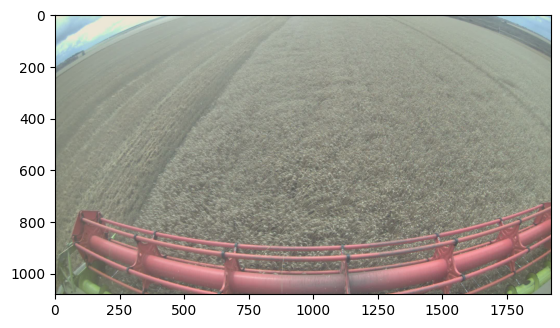

In [13]:
# Параметры центральной проекции
f_x = 943.37 # пиксельное фокусное расстояние по оси X
f_y = 943.37 # пиксельное фокусное расстояние по оси Y
u_x = 990.38 # координаты центрального пикселя (principal point) по X 
u_y = 487.67 # координаты центрального пикселя (principal point) по Y

# Матрица центральной проекции
K = np.array(
    [
        [f_x, 0.0, u_x],
        [0.0, f_y, u_y],
        [0.0, 0.0, 1.0]
    ],
    dtype=np.float32 # opencv работает с float32
)

# Параметры радиальной дисторсии
k_1 = -0.3229
k_2 = 0.1042
k_3 = -0.0148

D = np.array([k_1, k_2, 0.0, 0.0, k_3], dtype=np.float32)

# Размеры изображения
image_size = (1920, 1080)

# Углы поворота с.к. камеры
r_1 = -6.3445
r_2 = -0.0157
r_3 = -0.0416

# координаты установки камеры в с.к. робота
t_1 = -0.378
t_2 = 2.400
t_3 = 3.915

print('K = ', K)
print('D = ', D)
print('image_size = ', image_size)


## Радиальная дисторсия

Будем изучать поведение преобразования на 

* сетке с константным шагом
* произвольно выбранных точках

Наша цель - изучить как и куда переходят точки при прямом и обратном преобразовании

In [14]:
def draw_grid(img, step, color):
    w = img.shape[1]
    h = img.shape[0]
    start = int(step / 2)
    for i in range(start, w, step):
        cv2.line(img, (i, 0), (i, h - 1), color, 3, cv2.LINE_AA)
    for i in range(start, h, step):
        cv2.line(img, (0, i), (w - 1, i), color, 3, cv2.LINE_AA)
    
    return img

def generate_circles(image_size, n):
    cmap = plt.cm.get_cmap("tab20", n)
    xs = np.random.randint(0, image_size[0] - 1, n)
    ys = np.random.randint(0, image_size[1] - 1, n)
    cmis = np.random.permutation(n)
    colors = [cmap(cmi) for cmi in cmis]
    colors = [(255 * c[0], 255 * c[1], 255 * c[2]) for c in colors]
    return [{'x': x, 'y': y, 'color': color} for x,y,color in zip(xs, ys, colors)]

def draw_circles(image, circles):
    for c in circles:
        cv2.circle(image, (int(c['x']), int(c['y'])), 20, c['color'], -1, cv2.LINE_AA)
    return image
        
def undistort_circles(circles, K, D):
    src = [(c['x'], c['y']) for c in circles]
    src = np.array(src, dtype=np.float32)
    src = src.reshape(-1,1,2)
    dst = cv2.undistortPoints(src, K, D, P=K)
    # print(src, dst)
    res = []
    for i,c in enumerate(circles):
        res.append({'x': dst[i,0,0], 'y': dst[i,0,1], 'color': c['color']})
    return res;
    
def prepare_distortion_grid_images(image_size, K, D):
    #img_src = np.zeros(image_size[-1::-1], dtype=np.uint8)
    img_src = 255 * np.ones((image_size[1], image_size[0], 3), dtype=np.uint8)
    img_src = draw_grid(img_src, step=100, color=(220, 100, 100))
    return img_src

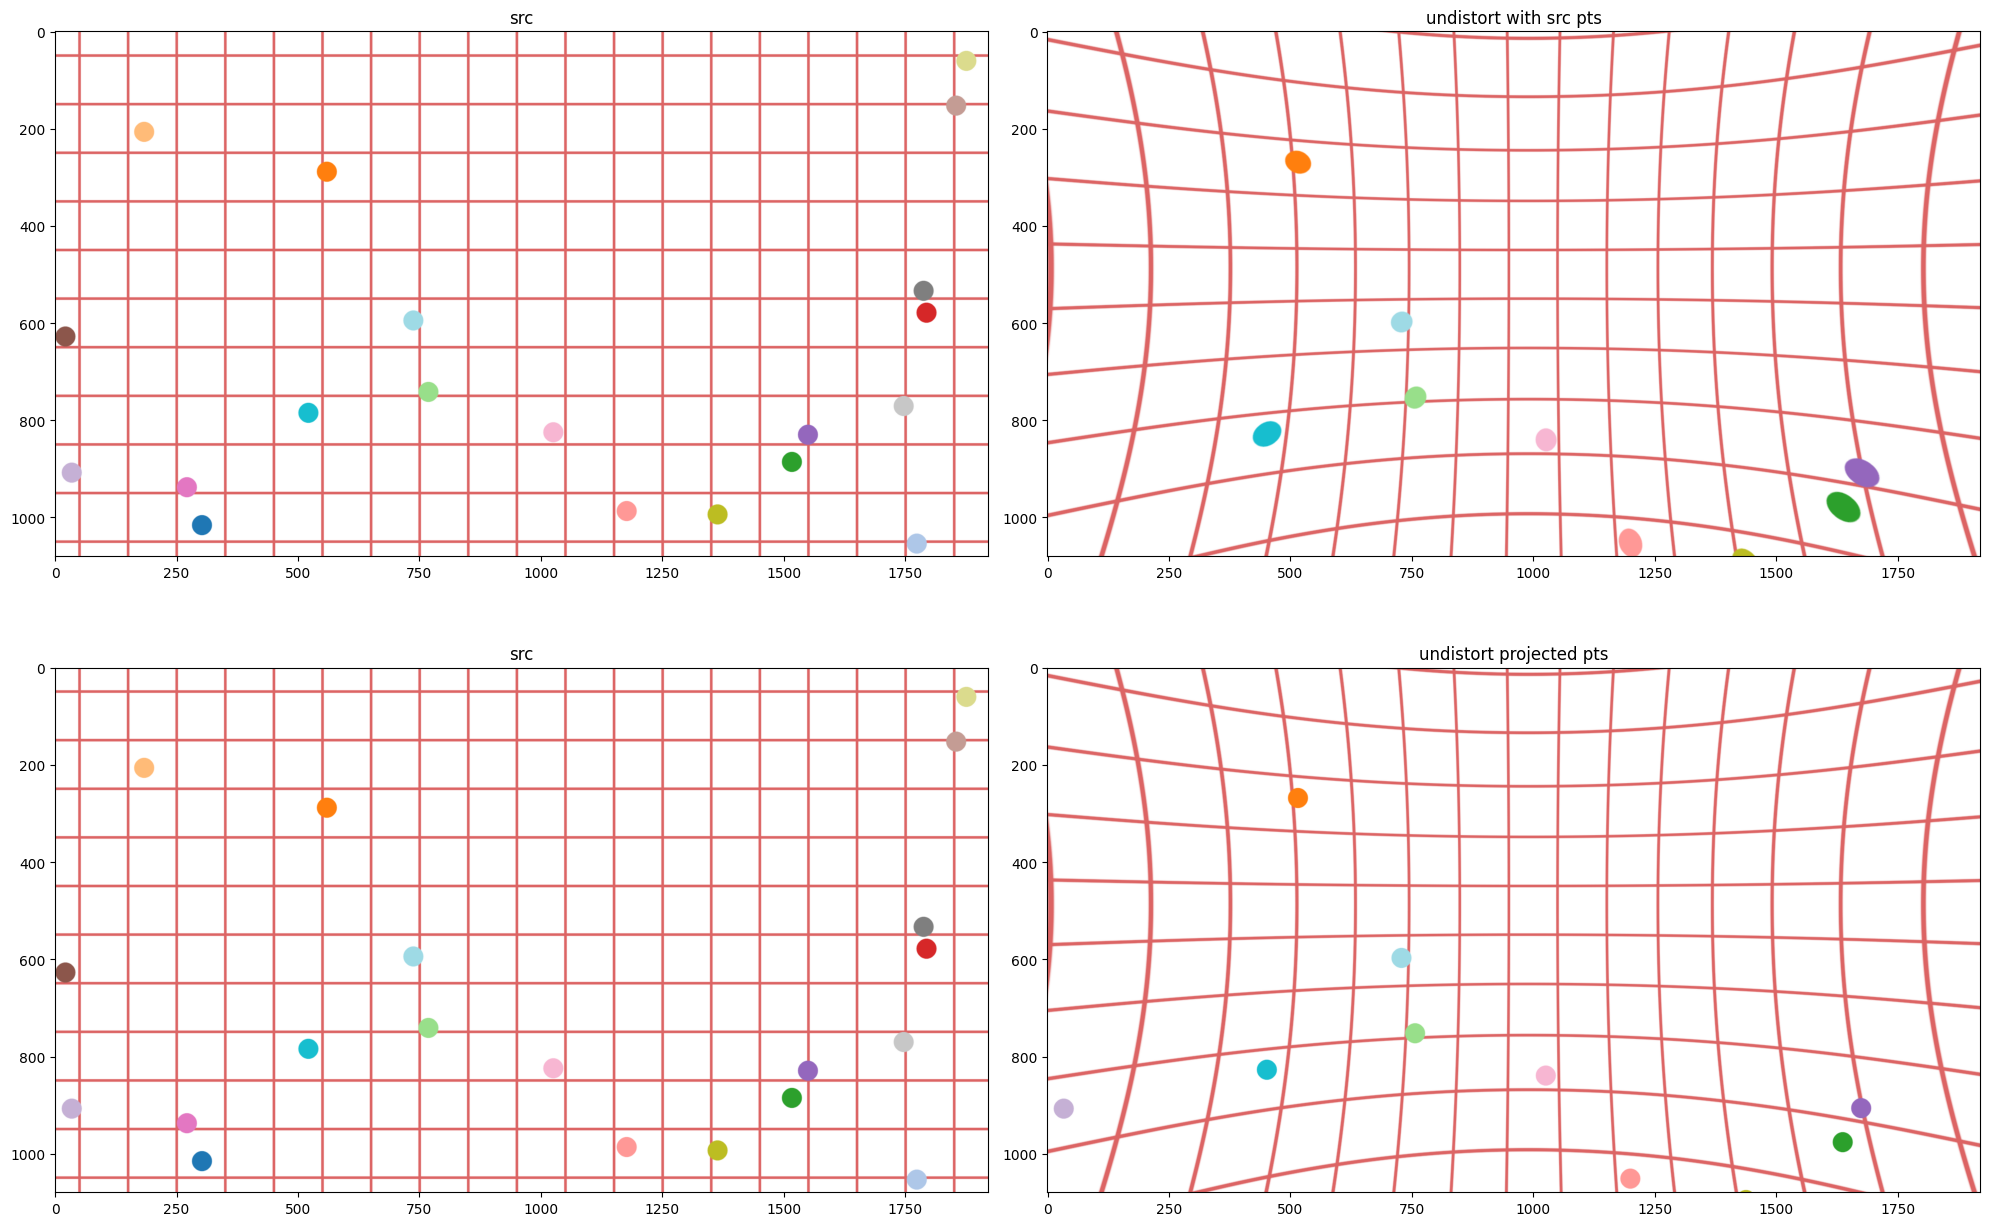

In [15]:
img_src = prepare_distortion_grid_images(image_size, K, D)
img_und = cv2.undistort(img_src, K, D)


circles_src = generate_circles(image_size, 20)
img_src_p = draw_circles(img_src.copy(), circles_src)
img_und_p = cv2.undistort(img_src_p, K, D)
circles_und = undistort_circles(circles_src, K, D)
img_und_p_2 = draw_circles(img_und.copy(), circles_und)

plt.figure(figsize=(20,13))
plt.subplot(221)
plt.imshow(img_src_p)
plt.title('src')
plt.subplot(222)
plt.imshow(img_und_p)
plt.title('undistort with src pts')
plt.subplot(223)
plt.imshow(img_src_p)
plt.title('src')
plt.subplot(224)
plt.imshow(img_und_p_2)
plt.title('undistort projected pts')
plt.tight_layout()
plt.show()

Не стоит путать картинки: слева (src) изображение с дисторсией. 
Справа - исправленная дисторсия. 

Искажение сетки показывает, куда сдвигаются пиксели исходного изображения при преобразовании

In [18]:
src = i.copy()
und = cv2.undistort(src, K, D)
src_mask = img_src_p != 255
und_mask = img_und_p_2 != 255

und[und_mask] = img_und_p_2[und_mask]
src[src_mask] = img_src_p[src_mask]

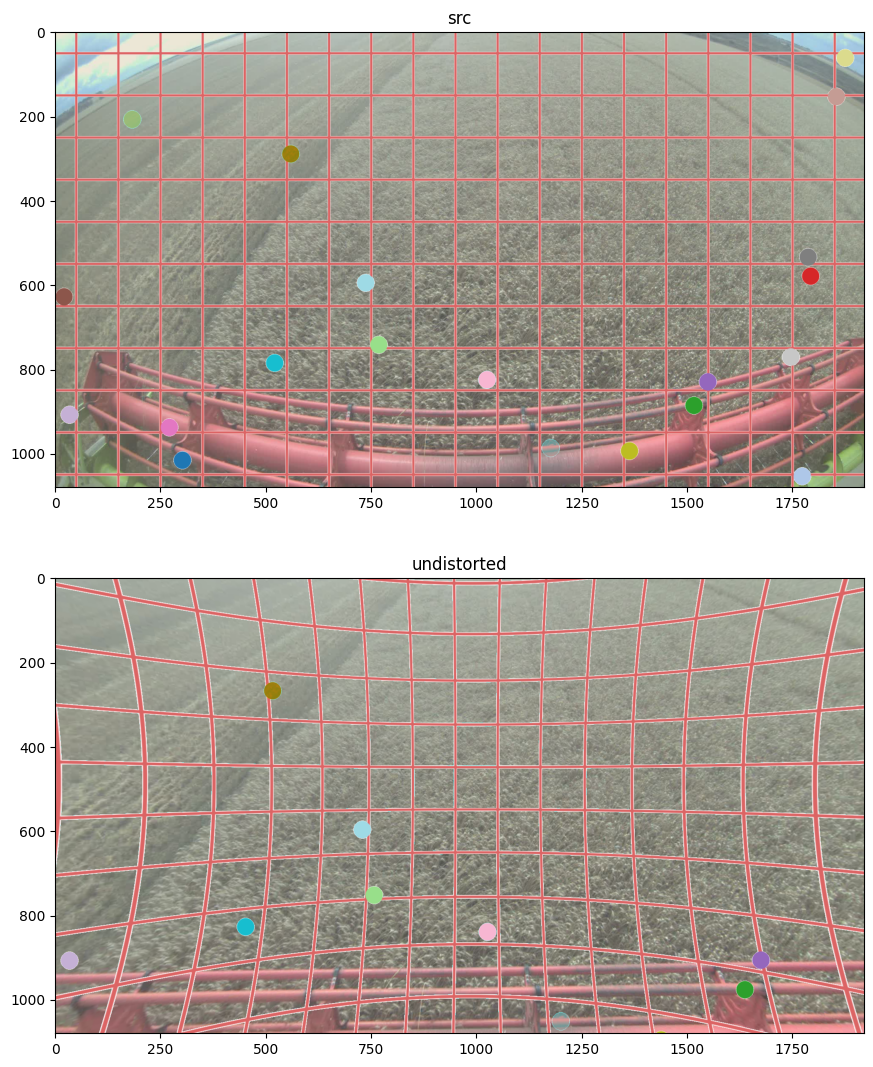

In [19]:
plt.figure(figsize=(20,13))
plt.subplot(211)
plt.imshow(src)
plt.title('src')
plt.subplot(212)
plt.imshow(und)
plt.title('undistorted')
plt.show()

Итак, мы продемонстрировали, как трансформируются точки из src в undistort. Но как узнать прообраз точки на und-изображении?

In [20]:
def distortPoints(src, K, k1, k2, k3, P):
    n = len(src)
    homogenous_points = np.dstack([src, np.ones((n,1,1), dtype=np.float32)])
    h_p = homogenous_points.reshape(n,-1).T
    uniform_coords = np.linalg.inv(K) @ h_p
    xs = uniform_coords[0,:]
    ys = uniform_coords[1,:]
    
    r2 = xs ** 2 + ys ** 2
    r4 = r2 ** 2
    r6 = r4 * r2
    coef = (1 + k1 * r2 + k2 * r4 + k3 * r6)
    xs1 = xs * coef
    ys1 = ys * coef
    res = np.vstack([xs1, ys1, np.ones(n, dtype=np.float32)])
    res = P @ res
    res = res[:2].T.reshape(-1,1,2)
    return res

def distort_circles(circles, K, D):
    src = [(c['x'], c['y']) for c in circles]
    src = np.array(src, dtype=np.float32)
    src = src.reshape(-1,1,2)
    dst = distortPoints(src, K, D[0], D[1], D[4], P=K)
    res = []
    for i,c in enumerate(circles):
        res.append({'x': dst[i,0,0], 'y': dst[i,0,1], 'color': c['color']})
    return res;

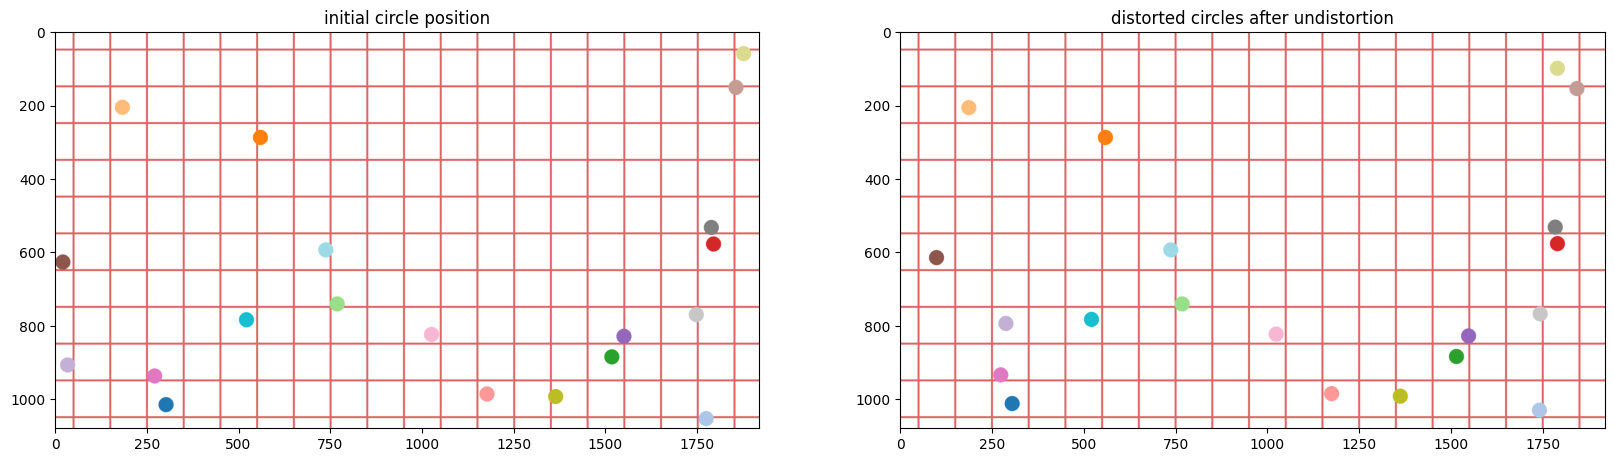

[[ 2.9261475e+00  3.3294678e-01]
 [ 9.1552734e-03  2.4536133e-02]
 [ 1.0073242e+01 -3.9036560e+00]
 [-7.8240234e+01  1.1326233e+01]
 [-3.5182495e+00  2.2023926e+00]
 [ 3.1317383e+01  2.2662231e+01]
 [-2.5494025e+02  1.1204651e+02]
 [ 1.3061523e-01  1.7749023e-01]
 [-5.2490234e-03 -2.4108887e-03]
 [-4.1217041e+00 -1.4328613e+00]
 [ 0.0000000e+00  0.0000000e+00]
 [ 2.7375488e+00  1.0264893e+00]
 [ 3.1127930e-01  1.9067383e-01]
 [ 1.2207031e-04  6.1035156e-05]
 [ 8.4217041e+01 -4.0619629e+01]
 [-3.8713989e+00  2.9713135e+00]
 [-3.8391113e-02  2.4291992e-02]
 [ 2.6840820e+00  1.5612793e-01]
 [-6.1035156e-05  0.0000000e+00]
 [ 3.1469727e-01  2.3852539e-01]]


In [21]:
# circles = generate_circles(image_size, 20)
circles_distorted = distort_circles(circles_und, K, D)
img_src_p_2 = draw_circles(img_src.copy(), circles_distorted)
plt.figure(figsize=(20,13))
plt.subplot(121)
plt.imshow(img_src_p)
plt.title('initial circle position')
plt.subplot(122)
plt.imshow(img_src_p_2)
plt.title('distorted circles after undistortion')
plt.show()

p_src1 = np.array([[c['x'], c['y']] for c in circles_src], dtype=np.float32)
p_src2 = np.array([[c['x'], c['y']] for c in circles_distorted], dtype=np.float32)

print(p_src1 - p_src2)

### но как тогда работает функция cv2.undistortPoints?

необходимо обратить функцию `distortPoints`. 


$$
\left(
\begin{matrix}
x_{src} \\
y_{src}
\end{matrix}
\right)
=
\left(
\begin{matrix}
x_{dst} (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
y_{dst} (1 + k_1 r^2 + k_2 r^4 + k_3 r^6)
\end{matrix}
\right)
$$

где $r^2 = x_{dst}^2 + y_{dst}^2$


Воспользуемся пакетом символьных вычислений `sympy`

In [22]:
class DistortFunc:
    def __init__(self, K, D):
        self.k1 = D[0]
        self.k2 = D[1]
        self.k3 = D[4]
        self.fx = K[0,0]
        self.fy = K[1,1]
        self.cx = K[0,2]
        self.cy = K[1,2]
        
        self.F_sym, self.J_sym = self.__symbols()
        self.FN_sym, self.JN_sym = self.__nsymbols()
    
    def F(self, xy):
        return np.array(self.F_sym.evalf(subs={self.x:xy[0], self.y:xy[1]}), dtype=np.float32)
    def J(self, xy):
        return np.array(self.J_sym.evalf(subs={self.x:xy[0], self.y:xy[1]}), dtype=np.float32)
    
    def Fn(self, xy):
        return np.array(self.FN_sym.evalf(subs={self.x:xy[0], self.y:xy[1]}), dtype=np.float32)
    def Jn(self, xy):
        return np.array(self.JN_sym.evalf(subs={self.x:xy[0], self.y:xy[1]}), dtype=np.float32)
    
    def distort_pix(self, x, y):
        x1 = (x - self.cx) / self.fx
        y1 = (y - self.cy) / self.fy
        
        xy2 = self.F([x1,y1])
        x3 = self.fx * xy2[0][0] + self.cx
        y3 = self.fy * xy2[1][0] + self.cy
        return (x3, y3)
    
    def normalize_x(self, x):
        return (x - self.cx) / self.fx
    def normalize_y(self, y):
        return (y - self.cy) / self.fy   
    def unnormalize_x(self, x):
        return self.fx * x + self.cx
    def unnormalize_y(self, y):
        return self.fy * y + self.cy
    
    
    def __symbols(self):
        import sympy as sym

        self.x, self.y = sym.symbols('x, y')
        
        def r2(x, y):
            return x * x + y * y

        def d(x, y):
            r2_ = r2(x, y)
            r4_ = r2_ * r2_
            r6_ = r4_ * r2_
            return 1 + self.k1 * r2_ + self.k2 * r4_ + self.k3 * r6_

        def fx(x, y):
            return x * d(x, y)

        def fy(x, y):
            return y * d(x, y)

        F = sym.Matrix([fx(self.x, self.y), fy(self.x, self.y)])
        J = F.jacobian((self.x, self.y))
        return F,J
    
    def __nsymbols(self):
        import sympy as sym

        self.x, self.y = sym.symbols('x, y')
        
        def r2(x, y):
            return x * x + y * y

        def d(x, y):
            r2_ = r2(x, y)
            r4_ = r2_ * r2_
            r6_ = r4_ * r2_
            return 1 + self.k1 * r2_ + self.k2 * r4_ + self.k3 * r6_

        def fx(x, y):
            return x * d(x, y)

        def fy(x, y):
            return y * d(x, y)
        
        nx = self.normalize_x(self.x)
        ny = self.normalize_y(self.y)
        
        xx = fx(nx, ny)
        yy = fy(nx, ny)
        xxx = self.unnormalize_x(xx)
        yyy = self.unnormalize_y(yy)
        
        F = sym.Matrix([xxx, yyy])
        J = F.jacobian((self.x, self.y))
        return F,J        
        

In [23]:
circles_src[1:5], circles_und[1:5]

([{'x': 1176, 'y': 987, 'color': (255.0, 152.0, 150.0)},
  {'x': 1854, 'y': 153, 'color': (196.0, 156.0, 148.0)},
  {'x': 21, 'y': 628, 'color': (140.0, 86.0, 75.0)},
  {'x': 271, 'y': 938, 'color': (227.0, 119.0, 194.0)}],
 [{'x': 1200.1652, 'y': 1052.006, 'color': (255.0, 152.0, 150.0)},
  {'x': 2387.428, 'y': -53.71396, 'color': (196.0, 156.0, 148.0)},
  {'x': -762.16986, 'y': 741.3737, 'color': (140.0, 86.0, 75.0)},
  {'x': -73.656685, 'y': 1153.7542, 'color': (227.0, 119.0, 194.0)}])

In [25]:
df = DistortFunc(K, D)
print(df.distort_pix(1819.3844, 494.98703))
print(df.distort_pix(2081.6938, 872.96783))
print(df.distort_pix(-178.85303, 307.56543))


import scipy.optimize

def undistortPoint(xy_, cb = None, method="lm"):
    def func(xy):
        return df.Fn(xy).ravel() - xy_
    def jac(xy):
        return df.Jn(xy)
    root = scipy.optimize.root(func, xy_, jac=jac, callback=cb, method=method)
    #print(root)
    return root.x

print(undistortPoint([1699, 506]))
print(undistortPoint([1842, 809]))
print(undistortPoint([67, 365]))

(1658.5225, 493.56723)
(1753.8563, 757.2219)
(180.87262, 362.97632)
[1902.27785364  511.25821815]
[2370.27305226 1008.32595468]
[-623.22792674  273.30394388]


###  пронаблюдаем как происходит сходимость алгоиртма

In [26]:
class OptStats:
    def __init__(self, circles):
        self.cirlcles = circles
        self.N = len(circles)
        self.pthist={}
    def get_opt_cb(self, icircle):
        self.pthist[icircle] = []
        def cb(x,f):
            self.pthist[icircle].append(x)
        return cb

stats = OptStats(circles_src)
und_pts = []
for i,c in enumerate(circles_src):
    und_pt = undistortPoint([c['x'], c['y']], cb=stats.get_opt_cb(i), method='anderson')
    und_pts.append(und_pt)

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_root.py:255: RuntimeWarning: Method anderson does not use the jacobian (jac).
  warn('Method %s does not use the jacobian (jac).' % (method,),
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-conditioned matrix (rcond=1.56334e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-conditioned matrix (rcond=1.22752e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-conditioned matrix (rcond=1.07709e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_nonlin.py:1072: LinAlgWarning: Ill-conditioned matrix (rcond=8.13978e-17): result may not be accurate.
  gamma = solve(self.a, df_f)
/opt/homebrew/lib/python3.10/s

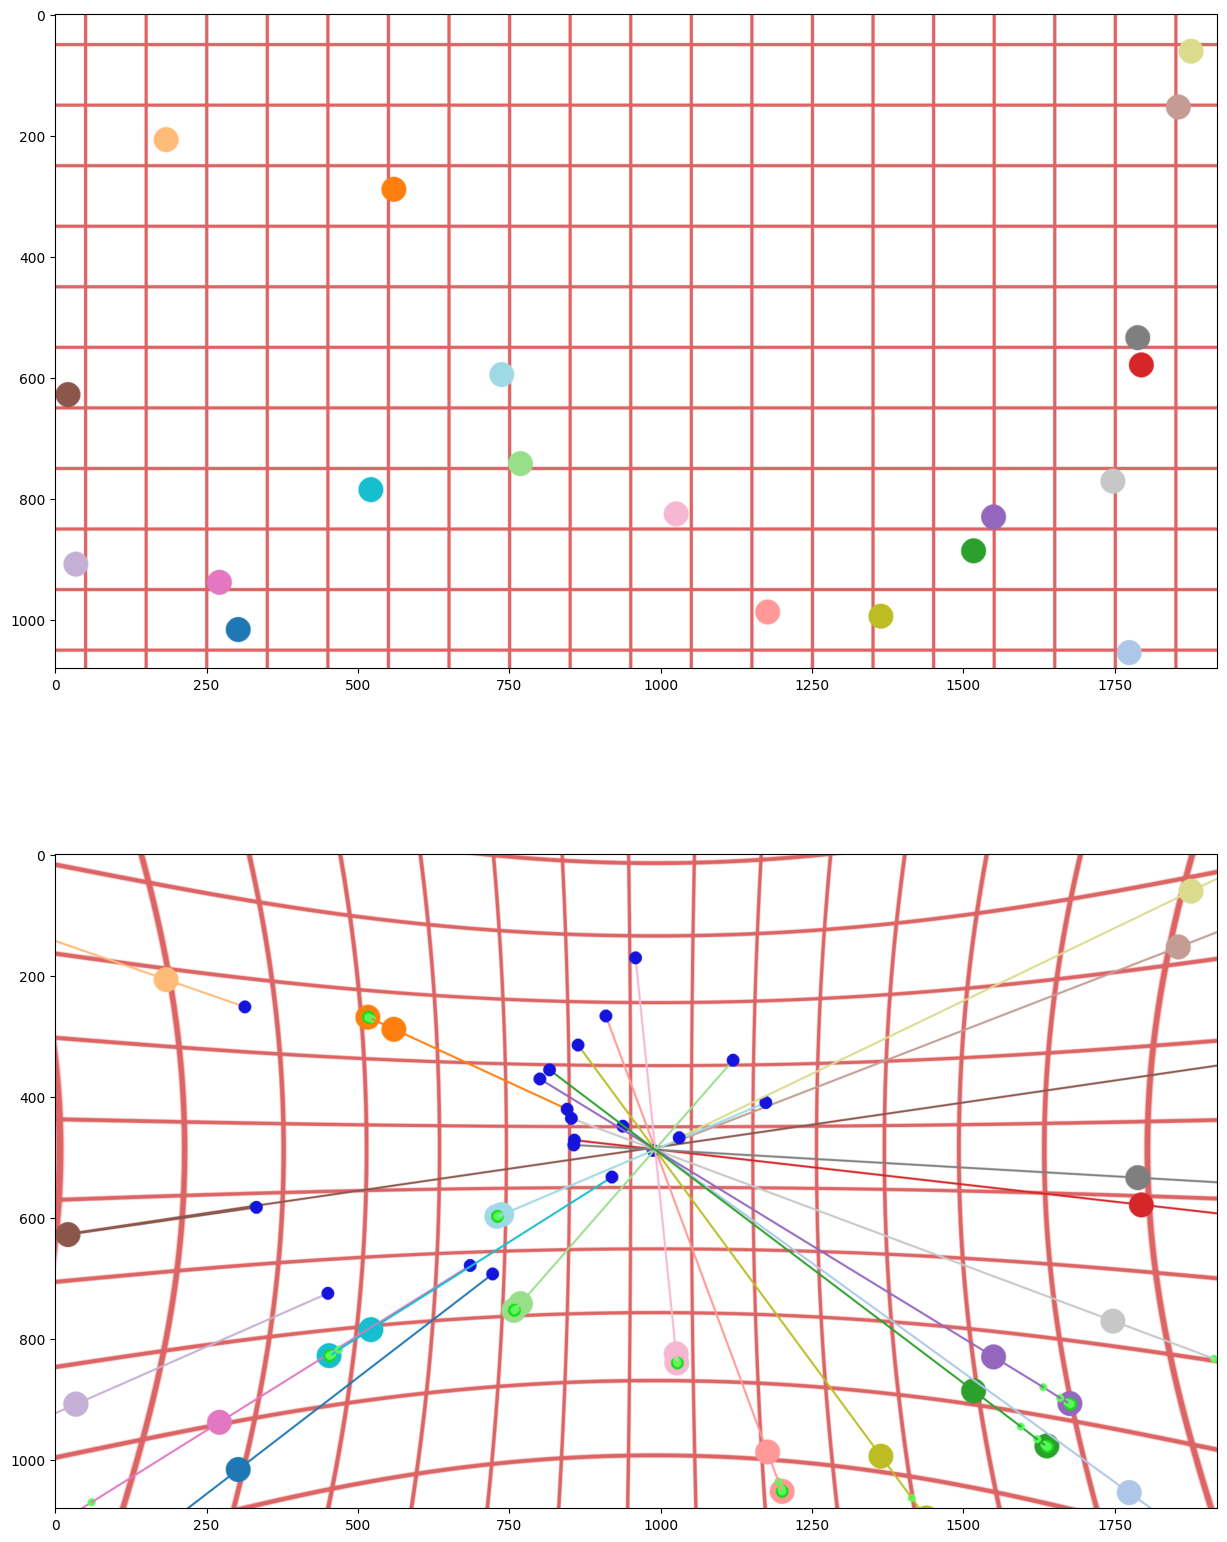

In [27]:

img_und_p_3 = draw_circles(img_und.copy(), circles_und)
img_ind_p_3 = draw_circles(img_und_p_3, circles_src)
for i, c in enumerate(circles_src):
    pp = tuple(np.rint(und_pts[i]).astype(np.int32))
    h = stats.pthist[i]
        
    cv2.circle(img_und_p_3, pp, 10, (20,220,20), -1, cv2.LINE_AA)
    
    for p in h[-2::-1]:
        p = tuple(np.rint(p).astype(np.int32))
        cv2.line(img_und_p_3, pp, p, c['color'], 2, cv2.LINE_AA)
        cv2.circle(img_und_p_3, p, 6, (90, 250, 90), -1, cv2.LINE_AA)
        pp = p
    cv2.circle(img_und_p_3, p, 10, (20,20,220), -1, cv2.LINE_AA)


plt.figure(figsize=(15,20))
plt.subplot(211)
plt.imshow(img_src_p)
plt.subplot(212)
plt.imshow(img_und_p_3)
plt.show()